In [8]:
import pandas as pd
from utils import get_control_clean
from utils import isc
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick
mpl.rc('font', family='Liberation Sans')

In [27]:
treated = pd.read_csv('./strata/hibyeth/ii_t_hi_nw.csv', index_col=0)
controls = pd.read_csv('./strata/hibyeth/ii_c_hi_nw.csv', index_col=0)
controls = controls[~(controls.pidp == 1020477375)]
target_var = 'ind_inc_deflated'
print('Data loaded...')
len(treated.pidp.unique())

Data loaded...


224

In [28]:
samples_nc = get_control_clean(controls, treated, [target_var], target_var, 'weight_yearx')
print('Data cleaned...')


Data cleaned...


In [29]:
samples_dc = get_control_clean(controls, treated, [target_var, 'dvage', 'sex_recoded', 'asian', 'black', 'mixed', 'other'], target_var, 'weight_yearx')

In [40]:
out_nc = isc(samples_nc, 100)

In [41]:
out_dc = isc(samples_dc, 100)

In [42]:
w_diffs_nc = pd.concat(out_nc['weighted_diff'], axis=1).sort_index()
w_diffs_dc = pd.concat(out_dc['weighted_diff'], axis=1).sort_index()

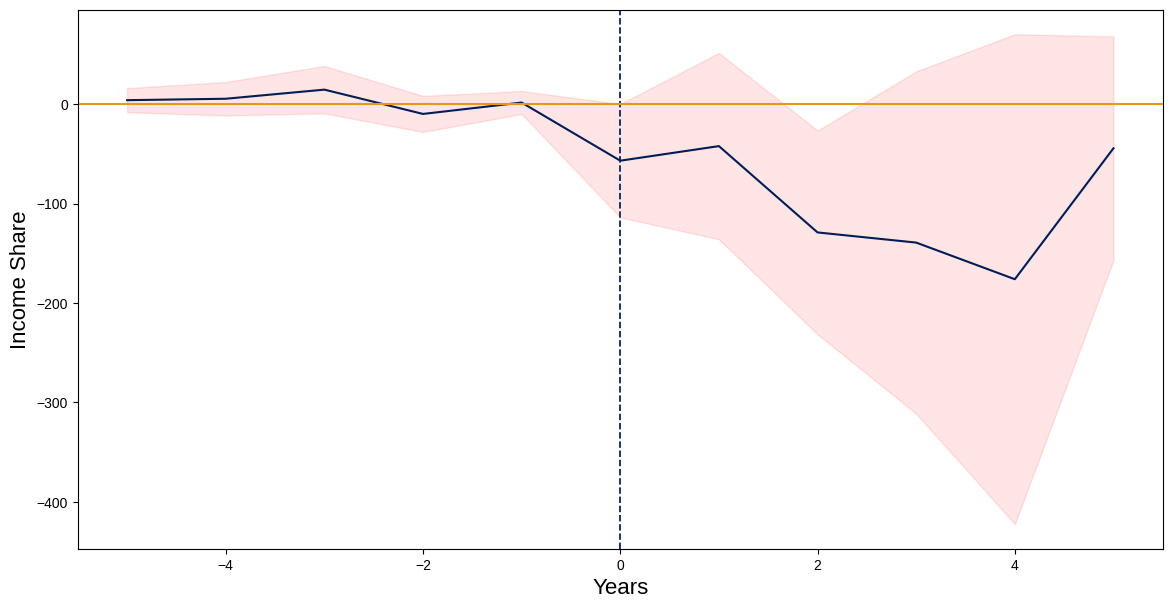

In [45]:
figure(figsize=(14, 7))
differences = w_diffs_dc[-5:5].copy()
ax = differences.mean(axis=1).plot(color='#001c54')
plt.axvline(x=0, linestyle='--', color='#001c54', alpha=1, linewidth=1.25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Income Share', fontsize=16)
plt.axhline(y=0, color='#E89818', linestyle='-')
plt.fill_between(x=differences.index,
                 y1=differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                 y2=differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.1)
#plt.tight_layout()
plt.show()